Relaxed entropy dual, where we estimate $\varphi$ only, replacing $\psi$ with first order optimality condition.

In [1]:
from data_utils import create_joint_x_y
import numpy as np
from torch import nn
import torch

def torch_sphere_uniform(n, d, **kwargs):
    """Generate n points inside the d-dimensional sphere."""
    random_vectors = torch.randn(n, d, **kwargs)
    vectors_norms = torch.norm(random_vectors, dim=1, keepdim=True)
    radius = torch.pow(torch.rand(n, 1, **kwargs), 1. / d)
    return radius * random_vectors / vectors_norms

num_points_to_generate = 1000
X, Y = create_joint_x_y(num_points_to_generate)

n, d = Y.shape
m = n

nu = np.ones((n, 1)) / n
mu = np.ones((m, 1)) / m

psi_network = nn.Sequential(
    nn.Linear(d + X.shape[1], 10),
    nn.ELU(),
    nn.Linear(10, 10),
    nn.ELU(),
    nn.Linear(10, 1)
)

In [2]:
import torch
torch.manual_seed(0)

device_and_dtype_specifications = dict(dtype=torch.float64, device=torch.device("cpu"))
epsilon = 1e-1
num_epochs = 5000

psi_network.to(**device_and_dtype_specifications)
psi_network_optimizer = torch.optim.Adam([dict(params=psi_network.parameters())], lr=0.01)

X, Y = create_joint_x_y(num_points_to_generate)
X_tensor = torch.tensor(X, **device_and_dtype_specifications)
Y_tensor = torch.tensor(Y, **device_and_dtype_specifications)
dataset_size = num_points_to_generate
batch_size = 256


def estimate_phi(X_tensor, U_tensor, X_dataset, Y_dataset, psi_net, k=5, epsilon=0.1):

        dists = torch.cdist(X_tensor, X_dataset, p=2.0)
        _, neighbor_indices = torch.topk(dists, k + 1, dim=1, largest=False)
        Y_neighbors = Y_dataset[neighbor_indices]

        cost_matrix = torch.einsum('ab,adb->ad', U_tensor, Y_neighbors) # n, m
        X_expanded_for_Y = X_tensor.unsqueeze(1).expand(-1, k + 1, -1)   # n, m, k
        slackness = cost_matrix - psi_net(torch.cat([X_expanded_for_Y, Y_neighbors], dim=-1)).squeeze() # n, m

        log_mean_exp = torch.logsumexp(slackness / epsilon, dim=1, keepdim=True) \
                - torch.log(torch.tensor(m, device=slackness.device, dtype=slackness.dtype))

        psi_estimate = epsilon * log_mean_exp

        return psi_estimate


for epoch_idx in range(1, num_epochs):

        psi_network.zero_grad()

        yindexes = torch.randint(0, dataset_size, (batch_size,))
        nnindexes = torch.randint(0, dataset_size, (dataset_size,))
        X_batch = X_tensor[yindexes]
        Y_batch = Y_tensor[yindexes]
        U_batch = torch.randn(
                batch_size, Y_batch.shape[1],
                **device_and_dtype_specifications
        )

        psi = psi_network(torch.cat([X_batch, Y_batch], dim=1))
        phi = estimate_phi(
                X_tensor=X_batch,
                X_dataset=X_tensor,
                Y_dataset=Y_tensor,
                U_tensor=U_batch,
                psi_net=psi_network,
                epsilon=epsilon,
                k=20
        )

        objective = torch.mean(phi) + torch.mean(psi)

        objective.backward()
        psi_network_optimizer.step()
        print(objective.item(), epoch_idx)

_ = psi_network.eval()

2.6845514046541856 1
1.795770531830684 2
1.3296361771246463 3
2.8656701311218797 4
2.3565842489002993 5
1.648303992116476 6
2.521653074572958 7
2.608902081168706 8
3.6954722030542566 9
2.559313599539807 10
2.7133041696486115 11
2.412243206587247 12
2.226875091151978 13
2.247728803923623 14
2.5302143804923483 15
2.76640554449712 16
2.376627439384909 17
2.056615520233505 18
2.7737616897997044 19
2.065692020439645 20
2.6624481400637157 21
1.8850665439883825 22
2.607565846581553 23
2.1545489600785204 24
2.2456817095194426 25
2.0467782811252166 26
2.1576215075406666 27
2.5207833523992185 28
2.2101300508522073 29
2.4462360249210735 30
1.6217751122713722 31
3.226090152981837 32
1.8869462781008366 33
2.361541524316622 34
1.4204283533066098 35
1.7951509519759519 36
2.7336870750817486 37
2.2151444540633807 38
1.7808045488660544 39
2.2780379113652116 40
1.6126264983761913 41
1.608577154133572 42
2.0442531592458217 43
1.8363110344895888 44
2.2275063867632356 45
2.289827108489057 46
1.8941999010938

In [3]:
import matplotlib.pyplot as plt

%matplotlib qt

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
number_of_points_to_visualize = 1000

with torch.no_grad():
        U_tensor = torch.randn(number_of_points_to_visualize, d, **device_and_dtype_specifications)
        UX_tensor = X_tensor[50:51].repeat(number_of_points_to_visualize, 1)
        potential_tensor = estimate_phi(
                X_tensor=UX_tensor,
                X_dataset=X_tensor,
                Y_dataset=Y_tensor,
                U_tensor=U_tensor,
                psi_net=psi_network,
                epsilon=epsilon,
                k=20
        )

potential = potential_tensor.detach().cpu().numpy()
U = U_tensor.detach().cpu().numpy()
scatter = ax.scatter(U[:, 0], U[:, 1], potential.squeeze(), color='red', marker='o', s=30, alpha=0.6)
ax.grid(True)

ax.view_init(elev=20, azim=120)
ax.set_xlabel('u1')
ax.set_ylabel('u2')
ax.set_zlabel('phi_u')

plt.show()

In [18]:
# Change to %matplotlib qt to have interactive plots
%matplotlib qt

from data_utils import create_conditional_x

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})
fig.suptitle('Separated 3D Plots', fontsize=16)

ax1.set_title('Conditional Scatter Data (y_x_gt)')
ax1.set_xlabel('Axis 0')
ax1.set_ylabel('Axis 1')
ax1.set_zlabel('x_ value')

for x_ in range(50, 250, 10):
    x = np.array([x_ / 100])[:, None]

    # This section is now active for the first plot
    _, y_x_gt = create_conditional_x(n_points=100, x_value=x_/100)
    z_scatter = np.full(y_x_gt.shape[0], x)
    ax1.scatter(y_x_gt[:, 0], y_x_gt[:, 1], z_scatter, color='blue', marker='o', s=30, alpha=0.2)

ax1.view_init(elev=-55, azim=154, roll=-83)

ax2.set_title('Contour Lines')
ax2.set_xlabel('Axis 0')
ax2.set_ylabel('Axis 1')
ax2.set_zlabel('x_ value')

loop_start_value = 50
for x_ in range(loop_start_value, 250, 10):

    x = torch.tensor([x_ / 100], **device_and_dtype_specifications)[:, None]
    x = x.repeat(repeats=(100, 1))

    colors = ['red', 'purple', 'green', 'orange', 'blue']
    radii = [0.1, 0.5, 1., 1.5, 2]
    for contour_radius, color in zip(radii, colors):
        pi_tensor = torch.linspace(-torch.pi, torch.pi, 100)
        u_tensor = torch.stack([
            contour_radius * torch.cos(pi_tensor),
            contour_radius * torch.sin(pi_tensor),
        ], dim=1)

        u_tensor = u_tensor.to(**device_and_dtype_specifications)
        u_tensor.requires_grad = True

        potential = estimate_phi(
                X_tensor=x,
                X_dataset=X_tensor,
                Y_dataset=Y_tensor,
                U_tensor=u_tensor,
                psi_net=psi_network,
                epsilon=epsilon,
                k=20
        )

        pushforward_of_u = torch.autograd.grad(potential.sum(), u_tensor)[0]

        z_line = x.detach().cpu().numpy()
        label = f'Radius {contour_radius}' if x_ == loop_start_value else ""
        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)
        ax2.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)

ax2.view_init(elev=-55, azim=154, roll=-83)
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

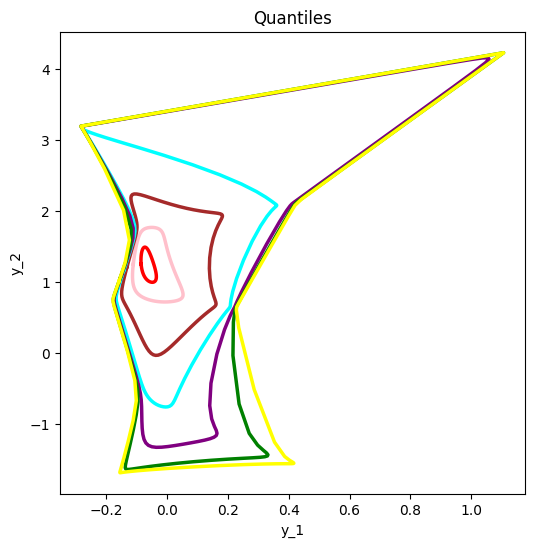

In [17]:
# Change to %matplotlib qt to have interactive plots
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

ax1.set_title('Quantiles')
ax1.set_xlabel('y_1')
ax1.set_ylabel('y_2')
x = torch.tensor([.7], **device_and_dtype_specifications)[:, None]
x = x.repeat(u_tensor.shape[0], 1)


colors = ['red', 'pink', 'brown', 'cyan', 'purple', 'green', 'yellow']
radii = [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4]
for contour_radius, color in zip(radii, colors):
        pi_tensor = torch.linspace(-torch.pi, torch.pi, 100)
        u_tensor = torch.stack([
            contour_radius * torch.cos(pi_tensor),
            contour_radius * torch.sin(pi_tensor),
        ], dim=1)

        u_tensor = u_tensor.to(**device_and_dtype_specifications)
        u_tensor.requires_grad = True


        potential = estimate_phi(
                X_tensor=x,
                X_dataset=X_tensor,
                Y_dataset=Y_tensor,
                U_tensor=u_tensor,
                psi_net=psi_network,
                epsilon=epsilon,
                k=11
        )

        pushforward_of_u = torch.autograd.grad(potential.sum(), u_tensor)[0]

        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], color=color, linewidth=2.5)
